## Using Model Pipelines

https://www.datacamp.com/tutorial/k-nearest-neighbor-classification-scikit-learn

https://www.datacamp.com/blog/classification-machine-learning

In [1]:
# Loading the Data
import pandas as pd
heart_df = pd.read_csv("../../TeamProject/data/raw/heart.csv")
heart_df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [2]:
# Split the data into features (X) and target (y)
X = heart_df.drop(columns='HeartDisease')
Y = heart_df['HeartDisease']

In [3]:
from sklearn.model_selection import train_test_split

#The scoring parameter determines the metric used to evaluate the performance of models during the cross-validation process.
scoring = [ 'accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Split the data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

## Preprocessing steps (scaling, encoding, transformations)

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
import numpy as np

In [5]:
heart_df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [6]:
categorical = ['ChestPainType', 'RestingECG','ST_Slope','Sex', 'ExerciseAngina', 'FastingBS']
numeric = ['Age', 'RestingBP', 'Cholesterol','MaxHR', 'Oldpeak']
numeric_power = [ 'Oldpeak']
numeric_standard = list(set(numeric) - set(numeric_power))

In [7]:
# Compute average of Cholesterol from training data (excluding zeros)
cholesterol_average = X_train[X_train['Cholesterol'] > 0]['Cholesterol'].mean()
cholesterol_average

245.5075376884422

In [8]:
# Custom imputer function to replace only zeros with the average
def replace_zeros_with_average(X):
    X = X.copy()  # Avoid modifying the original dataset
    X['Cholesterol'] = X['Cholesterol'].replace(0, cholesterol_average)
    return X

## Preprocessors
https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html


each transformer requires three elements:

+ A name (string) for the transformer.
+ The transformer itself ( imputer, scaler, encoder..).
+ The columns that the transformer should be applied to.
+ remainder='passthrough' option in a ColumnTransformer is used when you want to retain all columns that are not explicitly mentioned in the transformer and pass them through unchanged

In [9]:
preproc1 =  ColumnTransformer([
    ('scale_numeric', StandardScaler(), numeric),
    ('encode_cat', OneHotEncoder(handle_unknown = 'ignore', drop='first'), categorical)
])
preproc1

ColumnTransformer(transformers=[('scale_numeric', StandardScaler(),
                                 ['Age', 'RestingBP', 'Cholesterol', 'MaxHR',
                                  'Oldpeak']),
                                ('encode_cat',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore'),
                                 ['ChestPainType', 'RestingECG', 'ST_Slope',
                                  'Sex', 'ExerciseAngina', 'FastingBS'])])

In [10]:
preproc2 = ColumnTransformer([
    ('scale_numeric', StandardScaler(), numeric_standard),
    ('non_linear_scale_numeric', PowerTransformer(), numeric_power),
    ('encode_cat', OneHotEncoder(handle_unknown = 'ignore', drop='first'), categorical)
])
preproc2

ColumnTransformer(transformers=[('scale_numeric', StandardScaler(),
                                 ['MaxHR', 'Age', 'RestingBP', 'Cholesterol']),
                                ('non_linear_scale_numeric', PowerTransformer(),
                                 ['Oldpeak']),
                                ('encode_cat',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore'),
                                 ['ChestPainType', 'RestingECG', 'ST_Slope',
                                  'Sex', 'ExerciseAngina', 'FastingBS'])])

In [11]:
preproc3 = ColumnTransformer([
    ('replace_zeros', FunctionTransformer(replace_zeros_with_average, validate=False),['Cholesterol']),  # Custom imputer to replace Cholesterol zeros - validate=False:  doesn't need to validate the shape of the input
    ('scale_numeric', StandardScaler(), numeric), 
    ('encode_cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical)  # Encode categorical variables
])
preproc3

ColumnTransformer(transformers=[('replace_zeros',
                                 FunctionTransformer(func=<function replace_zeros_with_average at 0x1375e29d0>),
                                 ['Cholesterol']),
                                ('scale_numeric', StandardScaler(),
                                 ['Age', 'RestingBP', 'Cholesterol', 'MaxHR',
                                  'Oldpeak']),
                                ('encode_cat',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore'),
                                 ['ChestPainType', 'RestingECG', 'ST_Slope',
                                  'Sex', 'ExerciseAngina', 'FastingBS'])])

## Pipelines
### Using KNN Classifier to predict 'Heart Disease' or 'Normal'

In [12]:
# Pipeline A = preproc1 + KNeighborsClassifier
pipeline_A = Pipeline([
    ('preprocessing', preproc1),
    ('model', KNeighborsClassifier() )
])
pipeline_A

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('scale_numeric',
                                                  StandardScaler(),
                                                  ['Age', 'RestingBP',
                                                   'Cholesterol', 'MaxHR',
                                                   'Oldpeak']),
                                                 ('encode_cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['ChestPainType',
                                                   'RestingECG', 'ST_Slope',
                                                   'Sex', 'ExerciseAngina',
                                                   'FastingBS'])])),
                ('model', KNeighborsClassifier())])

In [13]:
# Pipeline B = preproc2 + KNeighborsClassifier
pipeline_B = Pipeline([
    ('preprocessing', preproc2),
    ('model', KNeighborsClassifier() )
])
pipeline_B

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('scale_numeric',
                                                  StandardScaler(),
                                                  ['MaxHR', 'Age', 'RestingBP',
                                                   'Cholesterol']),
                                                 ('non_linear_scale_numeric',
                                                  PowerTransformer(),
                                                  ['Oldpeak']),
                                                 ('encode_cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['ChestPainType',
                                                   'RestingECG', 'ST_Slope',
                                                   'Sex', 'ExerciseAngina',
                                                   'FastingBS'])])),
                ('model', KNeighborsClassifier())])

### Logistic Regression

https://www.ibm.com/think/topics/logistic-regression
https://www.datacamp.com/tutorial/understanding-logistic-regression-python

Logistic Regression is a supervised machine learning algorithm used to estimate the relationship between a dependent categorical variable and one or more independent variables. Unlike linear regression, which predicts continuous values, logistic regression classifies data into categories by computing the probability of an event occurence.

In [14]:
# Pipeline C = preproc1 + LogisticRegression
pipeline_C = Pipeline([
    ('preprocessing', preproc1),
    ('model', LogisticRegression(random_state=16)) 
])
pipeline_C

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('scale_numeric',
                                                  StandardScaler(),
                                                  ['Age', 'RestingBP',
                                                   'Cholesterol', 'MaxHR',
                                                   'Oldpeak']),
                                                 ('encode_cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['ChestPainType',
                                                   'RestingECG', 'ST_Slope',
                                                   'Sex', 'ExerciseAngina',
                                                   'FastingBS'])])),
                ('model', LogisticRegression(random_state=16))])

In [15]:
# Pipeline D = preproc2 + LogisticRegression
pipeline_D = Pipeline([
    ('preprocessing', preproc2),
    ('model', LogisticRegression(random_state=16)) 
])
pipeline_D

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('scale_numeric',
                                                  StandardScaler(),
                                                  ['MaxHR', 'Age', 'RestingBP',
                                                   'Cholesterol']),
                                                 ('non_linear_scale_numeric',
                                                  PowerTransformer(),
                                                  ['Oldpeak']),
                                                 ('encode_cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['ChestPainType',
                                                   'RestingECG', 'ST_Slope',
                                                   'Sex', 'ExerciseAngina',
                                                   'FastingBS'])])),
                ('model', LogisticRegression(random_state=16))])

In [16]:
# Pipeline E = preproc3 (zeros cholesterol replaced by average) + KNeighborsClassifier
pipeline_E = Pipeline([
    ('preprocessing', preproc3),
    ('model', KNeighborsClassifier() )
])
pipeline_E

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('replace_zeros',
                                                  FunctionTransformer(func=<function replace_zeros_with_average at 0x1375e29d0>),
                                                  ['Cholesterol']),
                                                 ('scale_numeric',
                                                  StandardScaler(),
                                                  ['Age', 'RestingBP',
                                                   'Cholesterol', 'MaxHR',
                                                   'Oldpeak']),
                                                 ('encode_cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['ChestPainType',
                                                   'RestingECG', 'ST_Slope',
                                                   'Sex', 'ExerciseAngina',
                                                   'FastingBS'])])),
                ('model', KNeighborsClassifier())])

In [17]:
# Pipeline F = preproc3 + LogisticRegression
pipeline_F = Pipeline([
    ('preprocessing', preproc3),
    ('model', LogisticRegression(random_state=16)) 
])
pipeline_F

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('replace_zeros',
                                                  FunctionTransformer(func=<function replace_zeros_with_average at 0x1375e29d0>),
                                                  ['Cholesterol']),
                                                 ('scale_numeric',
                                                  StandardScaler(),
                                                  ['Age', 'RestingBP',
                                                   'Cholesterol', 'MaxHR',
                                                   'Oldpeak']),
                                                 ('encode_cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['ChestPainType',
                                                   'RestingECG', 'ST_Slope',
                                                   'Sex', 'ExerciseAngina',
                                                   'FastingBS'])])),
                ('model', LogisticRegression(random_state=16))])

# Tune Hyperparams

### Grid for KNN Classifier ( Get best value of K) - dictionary of hyperparameters and values for tuning

In [18]:
#Parameter Grid for KNN Classifier - Pipeline A and B
param_grid_knn = {
    'model__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17,19, 21],  # Number of Nearest Neighbors
    'model__weights': ['uniform', 'distance'],  # Weighting scheme "uniform" (equal influence) vs "distance" (closer points matter more)
    'model__p': [1, 2]  # Distance metric: 1 = Manhattan (Sum of absolute differences), 2 = Euclidean (Straight-line distance)
}

### The **refit parameter** determines which metric will be used to select the best model and refit it on the entire training dataset after the grid search. 

The use of refit='f1' is preferred because the F1 score balances precision and recall, both of which are crucial in medical diagnoses. F1 is particularly important in this case, as the dataset is mildly imbalanced. The number of positive cases (508 records) is higher than the number of patients without heart disease (410 records), which can still lead to a slight imbalance in the dataset.

Accuracy measures the proportion of correct predictions (both positive and negative) out of all predictions. However, when the dataset is imbalanced, a model that predicts the majority class (e.g., predicting "no heart disease" for everyone) could still achieve high accuracy, even if it fails to correctly identify the positive class (patients with heart disease). This could cause bias toward the majority class, making accuracy less reliable as a performance metric in such scenarios.

Therefore, F1-score is preferred, as it gives a better indication of how well the model identifies the positive class while maintaining a balance between precision and recall.

#### Pipeline A

In [19]:
#Pipeline A
grid_knn_A = GridSearchCV(
    estimator=pipeline_A,
    param_grid=param_grid_knn,
    scoring=scoring,
    cv=5,
    refit = "f1"
)
grid_knn_A.fit(
    X_train, 
    Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('scale_numeric',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'RestingBP',
                                                                          'Cholesterol',
                                                                          'MaxHR',
                                                                          'Oldpeak']),
                                                                        ('encode_cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['ChestPainType',
                                                                          'RestingECG',
                                                                          'ST_Slope',
                                                                          'Sex',
                                                                          'ExerciseAngina',
                                                                          'FastingBS'])])),
                                       ('model', KNeighborsClassifier())]),
             param_grid={'model__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19,
                                                21],
                         'model__p': [1, 2],
                         'model__weights': ['uniform', 'distance']},
             refit='f1',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

#### Pipeline B

In [20]:
#Pipeline B
grid_knn_B = GridSearchCV(
    estimator=pipeline_B,
    param_grid=param_grid_knn,
    scoring=scoring,
    cv=5,
    refit = "f1"
)
grid_knn_B.fit(
    X_train, 
    Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('scale_numeric',
                                                                         StandardScaler(),
                                                                         ['MaxHR',
                                                                          'Age',
                                                                          'RestingBP',
                                                                          'Cholesterol']),
                                                                        ('non_linear_scale_numeric',
                                                                         PowerTransformer(),
                                                                         ['Oldpeak']),
                                                                        ('encode_cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['ChestPainType',
                                                                          'RestingECG',
                                                                          'ST_Slope',
                                                                          'Sex',
                                                                          'ExerciseAngina',
                                                                          'FastingBS'])])),
                                       ('model', KNeighborsClassifier())]),
             param_grid={'model__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19,
                                                21],
                         'model__p': [1, 2],
                         'model__weights': ['uniform', 'distance']},
             refit='f1',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [21]:
#Pipeline E
grid_knn_E = GridSearchCV(
    estimator=pipeline_E,
    param_grid=param_grid_knn,
    scoring=scoring,
    cv=5,
    refit = "f1"
)
grid_knn_E.fit(
    X_train, 
    Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('replace_zeros',
                                                                         FunctionTransformer(func=<function replace_zeros_with_average at 0x1375e29d0>),
                                                                         ['Cholesterol']),
                                                                        ('scale_numeric',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'RestingBP',
                                                                          'Cholesterol',
                                                                          'MaxHR',
                                                                          'Oldpeak']),
                                                                        ('encode_cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['ChestPainType',
                                                                          'RestingECG',
                                                                          'ST_Slope',
                                                                          'Sex',
                                                                          'ExerciseAngina',
                                                                          'FastingBS'])])),
                                       ('model', KNeighborsClassifier())]),
             param_grid={'model__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19,
                                                21],
                         'model__p': [1, 2],
                         'model__weights': ['uniform', 'distance']},
             refit='f1',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

### Grid for Logistic Regression

In [22]:
# Parameter grid for Logistic Regression - Pipeline C and D
param_grid_logreg = {
    'model__C': [0.01, 0.1, 1, 10, 100],  # Regularization strength - Lower(Strong): simpler model, less overfitting | Higher(Weaker): more flexibility, but may overfit
    'model__solver': ['liblinear', 'lbfgs']  # Optimization solver - liblinear: small datasets | lbfgs: Default/ large datasets
}

#### Pipeline C

In [23]:
grid_logreg_C = GridSearchCV(
    estimator=pipeline_C,
    param_grid=param_grid_logreg,
    scoring=scoring,  
    cv=5,                                                    
    verbose=1, #controls how much output GridSearchCV prints during training 1: Shows basic progress                       
    refit='f1' #If multiple metrics are used in scoring, refit decides which one to use for selecting the final best model.
)

grid_logreg_C.fit(X_train, Y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('scale_numeric',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'RestingBP',
                                                                          'Cholesterol',
                                                                          'MaxHR',
                                                                          'Oldpeak']),
                                                                        ('encode_cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['ChestPainType',
                                                                          'RestingECG',
                                                                          'ST_Slope',
                                                                          'Sex',
                                                                          'ExerciseAngina',
                                                                          'FastingBS'])])),
                                       ('model',
                                        LogisticRegression(random_state=16))]),
             param_grid={'model__C': [0.01, 0.1, 1, 10, 100],
                         'model__solver': ['liblinear', 'lbfgs']},
             refit='f1',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
             verbose=1)

In [24]:
grid_logreg_D = GridSearchCV(
    estimator=pipeline_D,
    param_grid=param_grid_logreg,
    scoring=scoring,  
    cv=5,                             
    n_jobs=-1,                        
    verbose=1,                        
    refit='f1'
)

grid_logreg_D.fit(X_train, Y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('scale_numeric',
                                                                         StandardScaler(),
                                                                         ['MaxHR',
                                                                          'Age',
                                                                          'RestingBP',
                                                                          'Cholesterol']),
                                                                        ('non_linear_scale_numeric',
                                                                         PowerTransformer(),
                                                                         ['Oldpeak']),
                                                                        ('encode_cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['ChestPainType',
                                                                          'RestingECG',
                                                                          'ST_Slope',
                                                                          'Sex',
                                                                          'ExerciseAngina',
                                                                          'FastingBS'])])),
                                       ('model',
                                        LogisticRegression(random_state=16))]),
             n_jobs=-1,
             param_grid={'model__C': [0.01, 0.1, 1, 10, 100],
                         'model__solver': ['liblinear', 'lbfgs']},
             refit='f1',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
             verbose=1)

In [25]:
grid_logreg_F = GridSearchCV(
    estimator=pipeline_F,
    param_grid=param_grid_logreg,
    scoring=scoring,  
    cv=5,                             
    n_jobs=-1,                        
    verbose=1,                        
    refit='f1'
)

grid_logreg_F.fit(X_train, Y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/midorikawaguti/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/midorikawaguti/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://s

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('replace_zeros',
                                                                         FunctionTransformer(func=<function replace_zeros_with_average at 0x1375e29d0>),
                                                                         ['Cholesterol']),
                                                                        ('scale_numeric',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'RestingBP',
                                                                          'Cholesterol',
                                                                          'MaxHR',
                                                                          'Oldpeak']),
                                                                        ('encode_cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['ChestPainType',
                                                                          'RestingECG',
                                                                          'ST_Slope',
                                                                          'Sex',
                                                                          'ExerciseAngina',
                                                                          'FastingBS'])])),
                                       ('model',
                                        LogisticRegression(random_state=16))]),
             n_jobs=-1,
             param_grid={'model__C': [0.01, 0.1, 1, 10, 100],
                         'model__solver': ['liblinear', 'lbfgs']},
             refit='f1',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
             verbose=1)

# Evaluating Classification Models

## Attributes of GridSearchCV
- **best_score_** : The best score obtained from the cross-validation process. This score is based on the evaluation metric specified in the scoring parameter

- **best_params_**: The hyperparameters that gave the best score.

- **best_estimator_**: The estimator (model) that gave the best score using the hyperparameters specified in best_params_

- **cv_results_**: A dictionary containing cross-validation results for all parameter combinations tested during the grid search. This includes a variety of evaluation metrics. Key entries in cv_results_ include: 
    - mean_test_score: The mean score obtained for each parameter set across the folds.
    - std_test_score: The standard deviation of the test scores for each parameter set.
    - mean_train_score: The mean training score.
    - std_train_score: The standard deviation of the training scores.
    - params: The parameter combinations tested

Specific columns of cv_results_.Provide results for each combination of hyperparameters tested during the grid search.:
- 'mean_test_neg_mean_squared_error'
- 'mean_test_neg_mean_absolute_error'
- 'mean_test_max_error'
- 'mean_test_accuracy'
- 'mean_test_precision'
- 'mean_test_recall'




In [26]:
# Function to get the best scores for a specific pipeline
def best_scores(grid_search, pipeline_name):
    best_index = grid_search.best_index_  # index of the best-performing parameters for the model
    
    return {
        "Pipeline": pipeline_name,
        "Best Params": grid_search.best_params_,
        "Best Accuracy": grid_search.cv_results_["mean_test_accuracy"][best_index],
        "Best Precision": grid_search.cv_results_["mean_test_precision"][best_index],
        "Best Recall": grid_search.cv_results_["mean_test_recall"][best_index],
        "Best F1": grid_search.cv_results_['mean_test_f1'][best_index],         
        "Best roc_auc": grid_search.cv_results_['mean_test_roc_auc'][best_index]
    }

# Add the best score for each pipeline in a list
results = [
    best_scores(grid_knn_A, "KNN A"),
    best_scores(grid_knn_B, "KNN B"),
    best_scores(grid_logreg_C, "LogReg C"),
    best_scores(grid_logreg_D, "LogReg D"),
    best_scores(grid_knn_E, "KNN E"),
    best_scores(grid_logreg_F, "LogReg F")
]

results_df = pd.DataFrame(results)
results_df.sort_values(by="Best F1", ascending=False) #Sorted by F1



,Pipeline,Best Params,Best Accuracy,Best Precision,Best Recall,Best F1,Best roc_auc
1,KNN B,"{'model__n_neighbors': 11, 'model__p': 1, 'mod...",0.877365,0.872848,0.910340,0.890494,0.918787
0,KNN A,"{'model__n_neighbors': 19, 'model__p': 1, 'mod...",0.873302,0.872441,0.900401,0.885887,0.924925
5,LogReg F,"{'model__C': 0.1, 'model__solver': 'lbfgs'}",0.870571,0.863388,0.907809,0.884844,0.924826
2,LogReg C,"{'model__C': 0.1, 'model__solver': 'lbfgs'}",0.866471,0.864543,0.897840,0.880629,0.922793
3,LogReg D,"{'model__C': 1, 'model__solver': 'liblinear'}",0.865120,0.864067,0.895309,0.879078,0.923237
4,KNN E,"{'model__n_neighbors': 11, 'model__p': 1, 'mod...",0.807930,0.809615,0.847963,0.828045,0.882955


- **High Accuracy**: The percentage of total correct predictions out of all predictions. It helps to understand if the model correctly classifies most cases, but it doesn’t reveal if it’s missing important cases, like someone with heart disease.

- **High Recall**: Identifies how many actual positive cases were correctly identified. Higher recall means fewer false negatives. For example, recall equal to 0.9 means the model identifies 90 out of 100 cases of heart disease, but 10 patients with a higher risk of heart disease are missed.

- **High Precision**: Identifies how many of the predicted positive cases were actually correct. Higher precision means fewer false positives. For example, recall equal to 0.88 means that out of 100 predicted positive cases, 88 patients were correctly identified, but 12 of them did not actually have heart disease.

- **High F1**:  It combines both precision and recall into a single metric, balancing the trade-off between them. In cases like predicting heart disease, where both false positives and false negatives are critical, the F1-score provides a single metric to assess overall performance.

- **-High ROC AUC**:  (Receiver Operating Characteristic - Area Under the Curve)
area under the ROC curve, which plots the true positive rate (recall) against the false positive rate (1 - specificity) at various threshold settings. Helps you understand how well the model distinguishes between the classes. 

    A higher ROC AUC means the model is better at distinguishing between heart disease and no heart disease. It's particularly useful for imbalanced datasets where accuracy alone can be misleading. An ROC AUC score of 1.0 means perfect classification, and 0.5 means the model performs no better than random guessing.

In [27]:
import numpy as np
pipelines = results_df["Pipeline"]
x = np.arange(len(pipelines))  # Bar positions
x

array([0, 1, 2, 3, 4, 5])

In [28]:
width = 0.2  # Width of each bar

x - 1.5 * width

array([-0.3,  0.7,  1.7,  2.7,  3.7,  4.7])

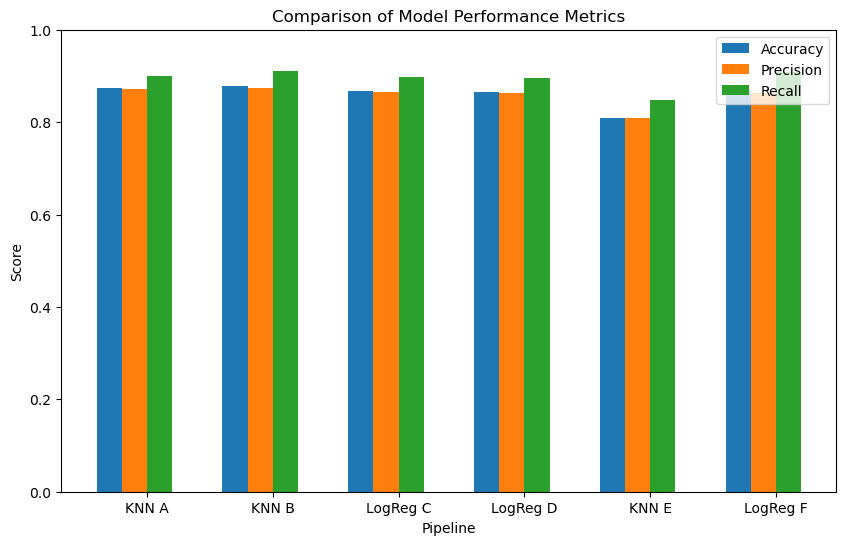

In [29]:
import numpy as np
import matplotlib.pyplot as plt
pipelines = results_df["Pipeline"]
accuracy = results_df["Best Accuracy"]
precision = results_df["Best Precision"]
recall = results_df["Best Recall"]

# Defining positions for bars
x = np.arange(len(pipelines))  # Bar positions
width = 0.2  # Width of each bar

# Creating the grouped bar chart
fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - 1.5 * width, accuracy, width, label="Accuracy")
rects2 = ax.bar(x - 0.5 * width, precision, width, label="Precision")
rects3 = ax.bar(x + 0.5 * width, recall, width, label="Recall")

# Formatting the plot
ax.set_xlabel("Pipeline")
ax.set_ylabel("Score")
ax.set_title("Comparison of Model Performance Metrics")
ax.set_xticks(x)
ax.set_xticklabels(pipelines)
ax.set_ylim(0, 1)  # Scores are between 0 and 1
ax.legend()

# Display plot
plt.show()


In [30]:
models = {
    "KNN": grid_knn_A
}
models.items()

dict_items([('KNN', GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('scale_numeric',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'RestingBP',
                                                                          'Cholesterol',
                                                                          'MaxHR',
                                                                          'Oldpeak']),
                                                                        ('encode_cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignor

In [31]:
import pandas as pd

# models in a dictionary with their respective pipeline names
models = {
    "KNN A": grid_knn_A, 
    "KNN B": grid_knn_B,
    "KNN E": grid_knn_E,
    "Log Regression C": grid_logreg_C,
    "Log Regression D": grid_logreg_D,
    "Log Regression F": grid_logreg_F,
    
}

# empty list to store results
results = []

# Loop through each model and get the mean test scores from cv_results_
for model_name, grid_search in models.items():
    best_index = grid_search.best_index_  # index of the best-performing parameters for the model
    model_results = {
        'accuracy': grid_search.cv_results_['mean_test_accuracy'][best_index],
        'precision': grid_search.cv_results_['mean_test_precision'][best_index],
        'recall': grid_search.cv_results_['mean_test_recall'][best_index],
        "Best F1": grid_search.cv_results_['mean_test_f1'][best_index],         
        "Best roc_auc": grid_search.cv_results_['mean_test_roc_auc'][best_index]
    }
    
    # Append the results for this model to the results list
    results.append(model_results)
print(results)


[{'accuracy': 0.8733016494268939, 'precision': 0.8724414899507676, 'recall': 0.9004012345679012, 'Best F1': 0.8858869471999851, 'Best roc_auc': 0.9249250590481933}, {'accuracy': 0.8773646444879322, 'precision': 0.8728479225522477, 'recall': 0.9103395061728395, 'Best F1': 0.8904936598839903, 'Best roc_auc': 0.9187872855140682}, {'accuracy': 0.8079302954058335, 'precision': 0.8096147350235613, 'recall': 0.8479629629629629, 'Best F1': 0.8280449003803374, 'Best roc_auc': 0.8829546920280752}, {'accuracy': 0.866470971950424, 'precision': 0.8645428647136161, 'recall': 0.8978395061728396, 'Best F1': 0.8806291527867899, 'Best roc_auc': 0.9227927701559542}, {'accuracy': 0.8651197465287485, 'precision': 0.8640667417715072, 'recall': 0.8953086419753087, 'Best F1': 0.879077620718889, 'Best roc_auc': 0.9232374533058613}, {'accuracy': 0.8705712421955084, 'precision': 0.8633882589180251, 'recall': 0.9078086419753086, 'Best F1': 0.8848444386821926, 'Best roc_auc': 0.9248264150627336}]


In [32]:
# Convert results to a DataFrame 
results_df = pd.DataFrame(results, index=models.keys())
results_df

,accuracy,precision,recall,Best F1,Best roc_auc
KNN A,0.873302,0.872441,0.900401,0.885887,0.924925
KNN B,0.877365,0.872848,0.910340,0.890494,0.918787
KNN E,0.807930,0.809615,0.847963,0.828045,0.882955
Log Regression C,0.866471,0.864543,0.897840,0.880629,0.922793
Log Regression D,0.865120,0.864067,0.895309,0.879078,0.923237
Log Regression F,0.870571,0.863388,0.907809,0.884844,0.924826


## SHAP  (SHapley Additive exPlanations)  Values and Interpretability
Measures how much each feature contributes to the model's prediction by assigning an importance values to each feature.

+ Positive SHAP values --> Positive Impact
+ Negative SHAP values --> Negative Impact

https://www.datacamp.com/tutorial/introduction-to-shap-values-machine-learning-interpretability

https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/model_agnostic/Census%20income%20classification%20with%20scikit-learn.html#Train-a-k-nearest-neighbors-classifier

In [33]:
# Pipeline grid_knn_A - best estimator
grid_knn_A.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('scale_numeric',
                                                  StandardScaler(),
                                                  ['Age', 'RestingBP',
                                                   'Cholesterol', 'MaxHR',
                                                   'Oldpeak']),
                                                 ('encode_cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['ChestPainType',
                                                   'RestingECG', 'ST_Slope',
                                                   'Sex', 'ExerciseAngina',
                                                   'FastingBS'])])),
                ('model',
                 KNeighborsClassifier(n_neighbors=19, p=1,
                                      weights='distance'))])

In [34]:
# Column transformer of pipeline grid_knn_A - best estimator
grid_knn_A.best_estimator_.named_steps['preprocessing']

ColumnTransformer(transformers=[('scale_numeric', StandardScaler(),
                                 ['Age', 'RestingBP', 'Cholesterol', 'MaxHR',
                                  'Oldpeak']),
                                ('encode_cat',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore'),
                                 ['ChestPainType', 'RestingECG', 'ST_Slope',
                                  'Sex', 'ExerciseAngina', 'FastingBS'])])

In [35]:
# Tranforming the X_test with the preprocessing steps of the grid_knn_A best estimator
X_test_transformed = grid_knn_A.best_estimator_.named_steps['preprocessing'].transform(X_test)
print(f'X_test_tranformed: {X_test_transformed.shape}')

X_train_transformed = grid_knn_A.best_estimator_.named_steps['preprocessing'].transform(X_train)
print(f'X_train_tranformed: {X_train_transformed.shape}')

X_test_tranformed: (184, 15)
X_train_tranformed: (734, 15)


In [36]:
# Getting the names of the preprocessing for each feature
feature_names= grid_knn_A.best_estimator_.named_steps['preprocessing'].get_feature_names_out()
feature_names

array(['scale_numeric__Age', 'scale_numeric__RestingBP',
       'scale_numeric__Cholesterol', 'scale_numeric__MaxHR',
       'scale_numeric__Oldpeak', 'encode_cat__ChestPainType_ATA',
       'encode_cat__ChestPainType_NAP', 'encode_cat__ChestPainType_TA',
       'encode_cat__RestingECG_Normal', 'encode_cat__RestingECG_ST',
       'encode_cat__ST_Slope_Flat', 'encode_cat__ST_Slope_Up',
       'encode_cat__Sex_M', 'encode_cat__ExerciseAngina_Y',
       'encode_cat__FastingBS_1'], dtype=object)

In [37]:
#Probability of 0 (normal) or 1 (heart disease) for each patient in the X_test
grid_knn_A.best_estimator_.predict_proba(X_test)[:, 1] 

array([0.05226128, 0.69556438, 0.91444597, 1.        , 0.14061367,
       0.5975528 , 0.8175829 , 0.15712817, 0.68806718, 0.89037461,
       0.73895809, 0.13976162, 0.7939962 , 0.15860861, 0.94932709,
       0.71967925, 0.07670563, 0.95582031, 0.76964562, 0.45410986,
       0.85262468, 0.90352852, 0.        , 0.53518582, 0.88895866,
       0.88590489, 0.        , 0.77470791, 0.        , 0.        ,
       0.74953169, 0.        , 0.60656046, 0.91738313, 0.89836515,
       0.21110009, 0.94193062, 0.        , 0.8076309 , 0.9045786 ,
       0.89640428, 0.84690264, 0.7836233 , 0.        , 0.05362596,
       0.58051784, 0.74999325, 1.        , 0.96591286, 0.78144216,
       0.11990735, 0.05370161, 0.96421182, 0.93971267, 0.2797797 ,
       0.05858896, 0.40065138, 0.72904065, 0.71758358, 0.89070469,
       0.08942994, 0.12469243, 0.        , 1.        , 0.        ,
       1.        , 0.93737735, 0.90243757, 1.        , 0.71615863,
       0.34088183, 0.04225213, 0.75078454, 0.87984073, 0.09531

In [38]:
#[:,1] selects the probability for class 1 (heart disease) for the patiencts in the X_test
grid_knn_A.best_estimator_.predict_proba(X_test)[:, 1] 

array([0.05226128, 0.69556438, 0.91444597, 1.        , 0.14061367,
       0.5975528 , 0.8175829 , 0.15712817, 0.68806718, 0.89037461,
       0.73895809, 0.13976162, 0.7939962 , 0.15860861, 0.94932709,
       0.71967925, 0.07670563, 0.95582031, 0.76964562, 0.45410986,
       0.85262468, 0.90352852, 0.        , 0.53518582, 0.88895866,
       0.88590489, 0.        , 0.77470791, 0.        , 0.        ,
       0.74953169, 0.        , 0.60656046, 0.91738313, 0.89836515,
       0.21110009, 0.94193062, 0.        , 0.8076309 , 0.9045786 ,
       0.89640428, 0.84690264, 0.7836233 , 0.        , 0.05362596,
       0.58051784, 0.74999325, 1.        , 0.96591286, 0.78144216,
       0.11990735, 0.05370161, 0.96421182, 0.93971267, 0.2797797 ,
       0.05858896, 0.40065138, 0.72904065, 0.71758358, 0.89070469,
       0.08942994, 0.12469243, 0.        , 1.        , 0.        ,
       1.        , 0.93737735, 0.90243757, 1.        , 0.71615863,
       0.34088183, 0.04225213, 0.75078454, 0.87984073, 0.09531

In [39]:
#Data tranform - X_test data transformed after preprocessing steps from grid_knn_A best estimator
# 734 records and 15 features (columns)
X_train_transformed

array([[-1.24506731, -0.70898547,  0.372803  , ...,  1.        ,
         0.        ,  1.        ],
       [-1.8862362 , -0.16628515,  0.08614581, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.25099346,  0.91911549,  0.12313384, ...,  1.        ,
         1.        ,  1.        ],
       ...,
       [ 0.67843939, -0.16628515,  0.49301407, ...,  1.        ,
         1.        ,  0.        ],
       [ 0.67843939,  1.02765555, -1.84647842, ...,  1.        ,
         1.        ,  0.        ],
       [-1.45879027,  0.91911549,  1.77834789, ...,  0.        ,
         0.        ,  0.        ]])

In [40]:
X_train_transformed.shape

(734, 15)

In [41]:
# To calculate the median for each feature we need to specify axis=0 (column-wise) 
#  return a 1D array (flat array: shape (15,) ) containing the median for each column: 15 elements in a single dimension
np.median(X_train_transformed, axis = 0)

array([ 0.03727049, -0.16628515,  0.2156039 ,  0.07196296, -0.28186743,
        0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        1.        ,  0.        ,  1.        ,  0.        ,  0.        ])

In [42]:
#Reshape into 2D array:  makes it a row vector (shape (1, 15)): 1 row and 15 columns
# SHAP Explainer Requires a 2D Input - without reshape it might throw a DimensionError.

#we use X_train because it is used as "background dataset" to explain prediction - X_train represent the typical values seen by the model
med = np.median(X_train_transformed, axis = 0).reshape((1, X_train_transformed.shape[1]))
med

array([[ 0.03727049, -0.16628515,  0.2156039 ,  0.07196296, -0.28186743,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         1.        ,  0.        ,  1.        ,  0.        ,  0.        ]])

In [43]:
import shap
import numpy as np
import pandas as pd

# Extract trained model and preprocessing steps
best_pipeline = grid_knn_A.best_estimator_
preprocessor = best_pipeline.named_steps["preprocessing"]  # preprocessing steps that were applied to the data (e.g., scaling, encoding)
knn_model = best_pipeline.named_steps["model"]  # KNN model that has been trained on the transformed data.

# Transform training and test data
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

#SHAP Explainers require a background dataset (the data used for reference when explaining a prediction).
#KNN models are sensitive to outliers and can be heavily influenced by extreme values. The median is more robust to outliers compared to the mean, and thus it’s a better choice to represent a typical instance when using KNN.
# Compute median of transformed training data (ensure correct shape)
med = np.median(X_train_transformed, axis=0).reshape((1, X_train_transformed.shape[1]))

# Get feature names
feature_names = preprocessor.get_feature_names_out(input_features=X_train.columns)
grid_knn_A.best_estimator_.named_steps['preprocessing'].get_feature_names_out()


#The function f(x) takes in the transformed data x and uses the trained KNN model to predict the probabilities of each class.
#predict_proba(x) returns the probabilities for each class, and [:, 1] selects the probability for class 1 (the positive class) in a binary classification task.
# Define prediction function
#Class 1 (Positive Class): Represents presence of heart disease.
def f(x):
    return knn_model.predict_proba(x)[:, 1]  

# Initialize SHAP explainer with transformed median as background (computed from X_train_transformed)
#https://shap.readthedocs.io/en/latest/generated/shap.Explainer.html
explainer = shap.Explainer(f, med, feature_names=feature_names, seed=42)

# Compute SHAP values on transformed test data
shap_values = explainer(X_test_transformed)

/Users/midorikawaguti/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# SHAP Summary (Beeswarm) Plot
How each feature impacts the model's output.

- Each dot a single prediction
- Most important feature = TOP
- X-axis shows SHAP values. indicate how much each feature contributes to the prediction for a given sample, relative to the average prediction for all samples.

- The colors (red and blue) do not indicate whether the feature is "good" or "bad"
    - **RED** (high feature value): The feature is at a high value for that observation.
    - **BLUE** (low feature value): The feature is at a low value for that observation.

- What matters is where these colors appear on the x-axis (SHAP values)
    - **RIGHT:** If high feature values (red) tend to be on the right (positive SHAP values), it means that higher values of this feature increase the likelihood of the positive class (e.g., presence of heart disease).
    - **LEFT:** If high feature values are on the left (negative SHAP values), then higher values decrease the likelihood of the positive class.



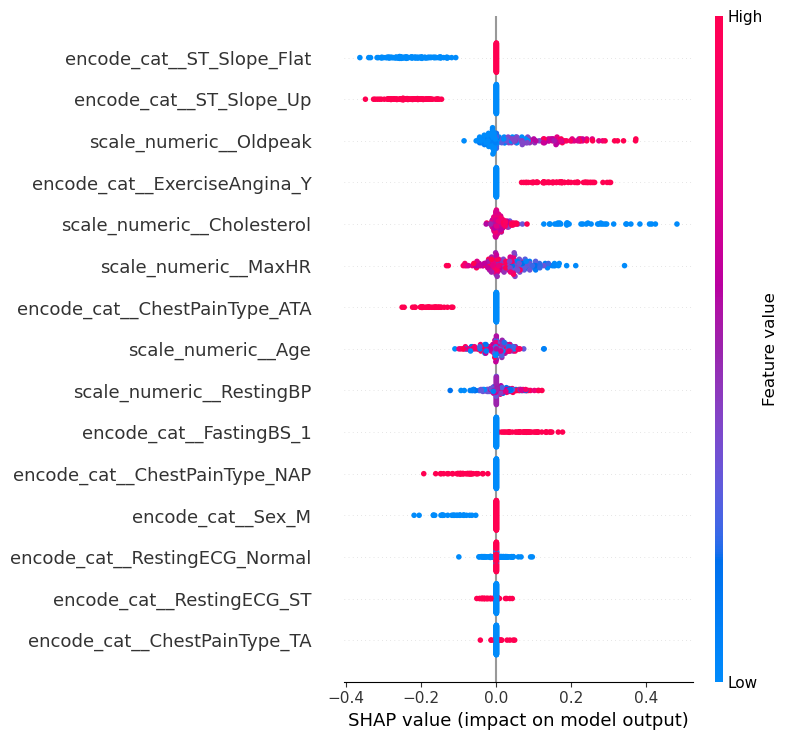

In [44]:
# Convert transformed X_test to DataFrame for visualization
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names)

# SHAP summary plot (with correct feature names)
shap.summary_plot(shap_values, X_test_transformed_df)

In [45]:
X_test_transformed_df

,scale_numeric__Age,scale_numeric__RestingBP,scale_numeric__Cholesterol,scale_numeric__MaxHR,scale_numeric__Oldpeak,encode_cat__ChestPainType_ATA,encode_cat__ChestPainType_NAP,encode_cat__ChestPainType_TA,encode_cat__RestingECG_Normal,encode_cat__RestingECG_ST,encode_cat__ST_Slope_Flat,encode_cat__ST_Slope_Up,encode_cat__Sex_M,encode_cat__ExerciseAngina_Y,encode_cat__FastingBS_1
0,0.999024,0.376415,-0.043312,1.691748,-0.836286,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.069591,0.647765,2.943471,-0.244093,-0.836286,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,1.212747,1.461816,-1.846478,-0.560148,0.272552,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0
3,0.250993,-0.166285,-1.846478,-0.560148,0.087745,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
4,0.037270,-1.360226,1.010846,0.783088,-0.836286,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,-0.390175,0.376415,0.816659,0.150977,-0.836286,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
180,0.999024,-1.360226,0.640966,1.296679,0.826971,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
181,1.105885,0.430685,0.409791,-0.797190,0.549761,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
182,-0.497037,-0.166285,0.613225,1.375693,-0.281867,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0


# Waterfall Plot

+ **Base Value (expected Model Output)** 
    - Found at the bottom of the Plot
    - Represents the average model prediction (for the whole dataset).

+ **Final Model Output (f(x))**
    - Found at the top of the plot
    - It is the final predicted probability (or value) for this specific instance.

+ **Positive SHAP values (red)**  → Increased probability of class 1.
+ **Negative SHAP values (blue)**  → Decreased probability of class 1.

In [46]:
# shap_values have 184 patients records
shap_values.shape

(184, 15)

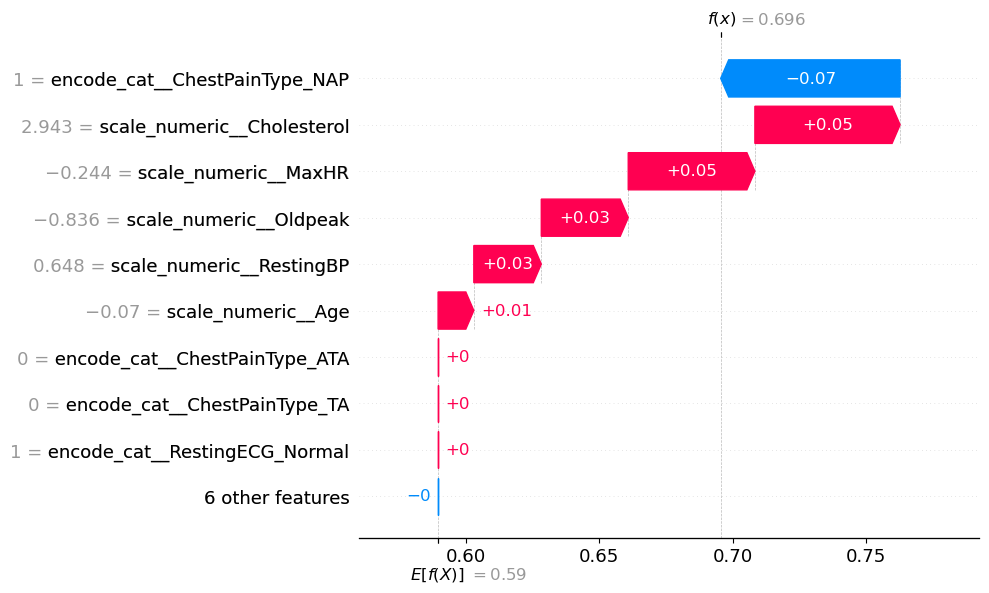

In [47]:
shap.plots.waterfall(shap_values[1])

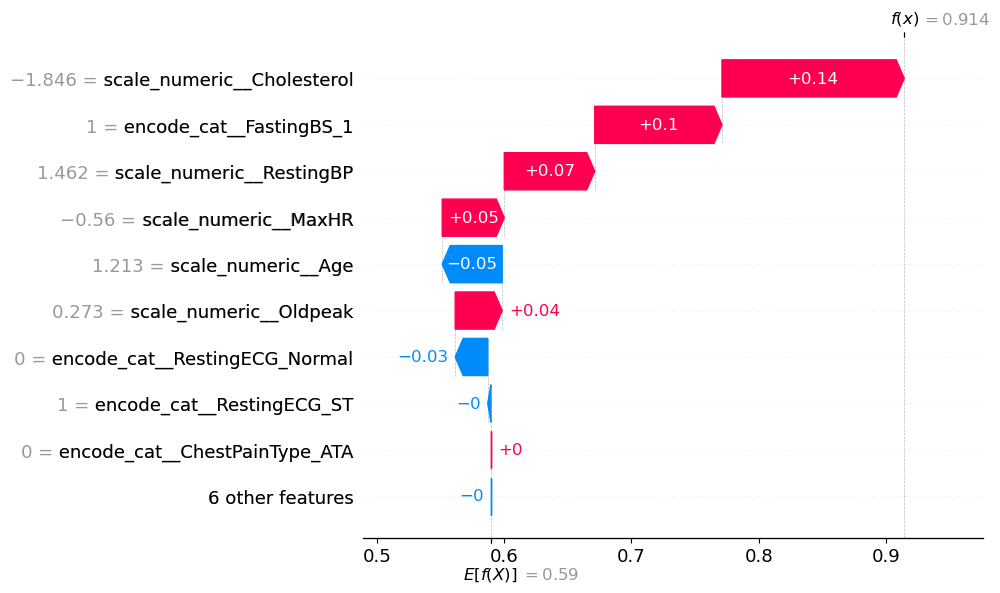

In [48]:
shap.plots.waterfall(shap_values[2])

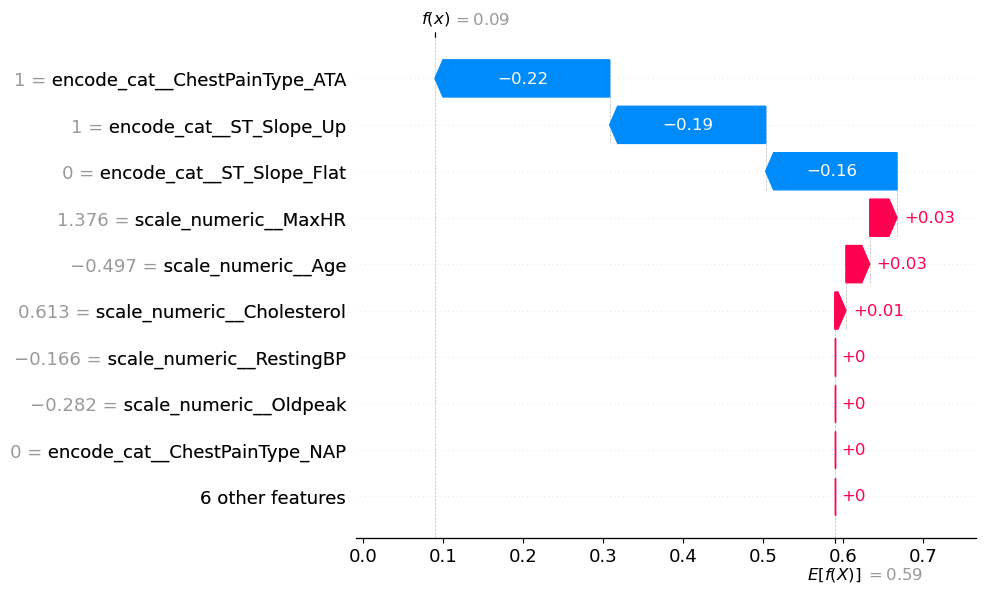

In [49]:
shap.plots.waterfall(shap_values[182])

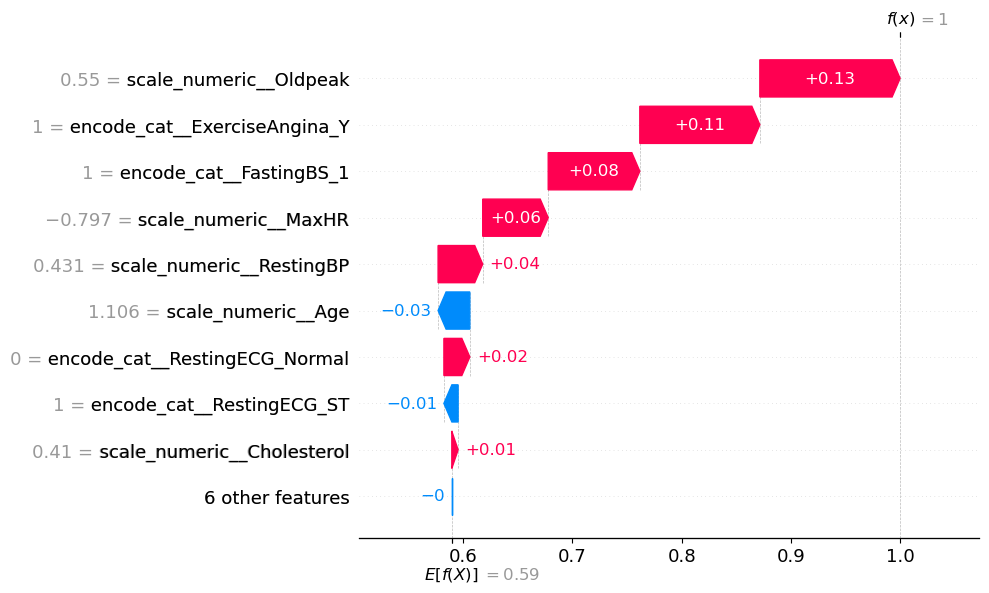

In [50]:
shap.plots.waterfall(shap_values[181])

In [51]:
# heart_df.tail(5)
X_test_transformed.shape

(184, 15)

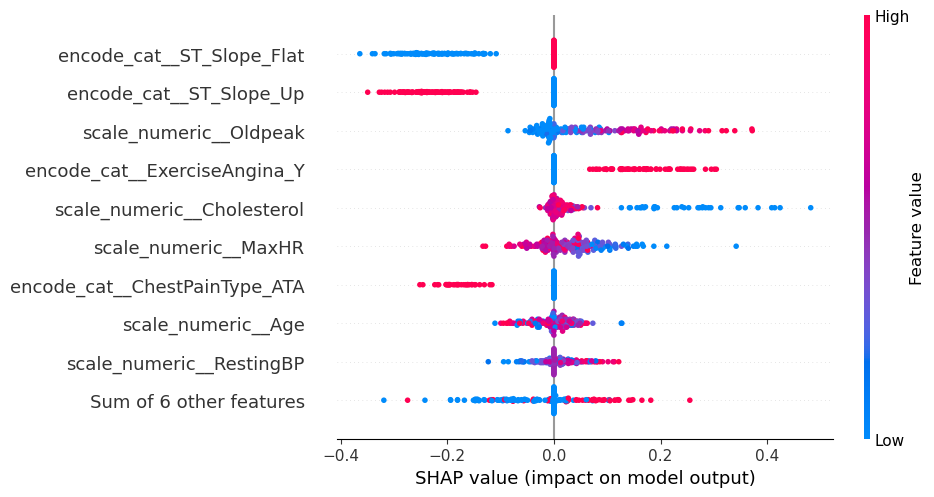

In [52]:
shap.plots.beeswarm(shap_values)